# Fast Agent - Build a SQL Agent fast!

<img src="./assets/LC_L1_top.png" align="left" width="500">

## Setup

Load and/or check for needed environmental variables

In [1]:
from dotenv import load_dotenv
from env_utils import doublecheck_env, doublecheck_pkgs

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env("example.env")  # check environmental variables
doublecheck_pkgs(pyproject_path="pyproject.toml", verbose=True)   # check packages

OPENAI_API_KEY=****p0UA
LANGSMITH_API_KEY=****77f2
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ials
Python 3.12.9 satisfies requires-python: >=3.11,<3.14
package                | required | installed | status | path                                                                            
---------------------- | -------- | --------- | ------ | --------------------------------------------------------------------------------
langgraph              | >=1.0.0  | 1.0.1     | ✅ OK   | …han/source/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain              | >=1.0.0  | 1.0.2     | ✅ OK   | …han/source/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-core         | >=1.0.0  | 1.0.1     | ✅ OK   | …han/source/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-openai       | >=1.0.0  | 1.0.1     | ✅ OK   | …han/source/lca-langchainV1-essentials/python/.venv/lib/python3.12/site-packages
langchain-anthrop

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

Define the runtime context to provide the agent and tools with access to the database.

In [3]:
from dataclasses import dataclass

from langchain_community.utilities import SQLDatabase


# define context structure to support dependency injection
@dataclass
class RuntimeContext:
    db: SQLDatabase

<b>⚠️ Security Note:</b> This demo does not include a filter on LLM-generated commands. In production, you would want to limit the scope of LLM-generated commands. ⚠️   
This tool will connect to the database. Note the use of `get_runtime` to access the graph **runtime context**.

In [4]:
from langchain_core.tools import tool
from langgraph.runtime import get_runtime

@tool
def execute_sql(query: str) -> str:
    """Execute a SQLite command and return results."""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

Add a system prompt to define your agents behavior.

In [5]:
SYSTEM_PROMPT = """You are a careful SQLite analyst.

Rules:
- Think step-by-step.
- When you need data, call the tool `execute_sql` with ONE SELECT query.
- Read-only only; no INSERT/UPDATE/DELETE/ALTER/DROP/CREATE/REPLACE/TRUNCATE.
- Limit to 5 rows of output unless the user explicitly asks otherwise.
- If the tool returns 'Error:', revise the SQL and try again.
- Prefer explicit column lists; avoid SELECT *.
"""

Create your agent! Add a model, tools, a prompt, and the runtime access, and go!  You can choose many agents from our [integrations](https://docs.langchain.com/oss/python/integrations/providers) list. 

In [6]:
from langchain.agents import create_agent

agent = create_agent(
    model="openai:gpt-5-mini",
    tools=[execute_sql],
    system_prompt=SYSTEM_PROMPT,
    context_schema=RuntimeContext,
)

Here's a display of the agent ReAct Loop.

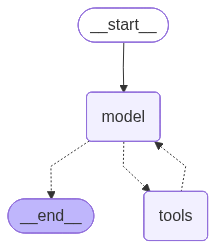

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Run some queries. Notice:
- The agent does not have the database schema and will need to discover it independently.
- The agent may make mistakes! By returning error messages, the agent can self-correct its queries.
- Notice you invoke the agent with `agent.stream`.
    - This command and the `pretty_print` display the **messages** that communicate information between the model and the tools.
- Notice the agent doesn't remember the schema between invocations... More on this later!

In [8]:
question = "Which table has the largest number of entries?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which table has the largest number of entries?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_QbpxxWWPTNbayY8HH1I0kMTz)
 Call ID: call_QbpxxWWPTNbayY8HH1I0kMTz
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',), ('Invoice',), ('InvoiceLine',), ('MediaType',), ('Playlist',), ('PlaylistTrack',), ('Track',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_feRKxmtla57C8LM0MW8FSu7n)
 Call ID: call_feRKxmtla57C8LM0MW8FSu7n
  Args:
    query: SELECT table_name, cnt FROM (
  SELECT 'Album' AS table_name, COUNT(*) AS cnt FROM Album
  UNION ALL SELECT 'Artist', 

In [9]:
question = "Which genre on average has the longest tracks?"

for step in agent.stream(
    {"messages": question},
    context=RuntimeContext(db=db),
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which genre on average has the longest tracks?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_4ZaTW8dOzQ92QKDPcLz8JkpM)
 Call ID: call_4ZaTW8dOzQ92QKDPcLz8JkpM
  Args:
    query: SELECT g.Name AS genre, AVG(t.Milliseconds) AS avg_milliseconds, AVG(t.Milliseconds)/1000.0 AS avg_seconds
FROM tracks t
JOIN genres g ON t.GenreId = g.GenreId
GROUP BY g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT g.Name AS genre, AVG(t.Milliseconds) AS avg_milliseconds, AVG(t.Milliseconds)/1000.0 AS avg_seconds
FROM tracks t
JOIN genres g ON t.GenreId = g.GenreId
GROUP BY g.Name
ORDER BY avg_milliseconds DESC
LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
=================

In [10]:
question = "Please list all of the tables"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Please list all of the tables
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_cMaEsLvUVxPhR1CoUKXA78L6)
 Call ID: call_cMaEsLvUVxPhR1CoUKXA78L6
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('Customer',), ('Employee',), ('Genre',)]
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_P2o2kdG1MMGJfJXjKQHXxGnS)
 Call ID: call_P2o2kdG1MMGJfJXjKQHXxGnS
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%' ORDER BY name;
================================= Tool Message =================================
Name: execute_sql

[('Album',), ('Artist',), ('

**Create your own query here!**  Add some questions of your own.

In [11]:
question = "Give a list of genres of tracks. And show me the SQL query you used to query the database to get a list of genres."

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Give a list of genres of tracks. And show me the SQL query you used to query the database to get a list of genres.
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_rx0RWEQGkyVndrUZNQa4AeMy)
 Call ID: call_rx0RWEQGkyVndrUZNQa4AeMy
  Args:
    query: SELECT GenreId, Name FROM Genre ORDER BY Name LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[(23, 'Alternative'), (4, 'Alternative & Punk'), (6, 'Blues'), (11, 'Bossa Nova'), (24, 'Classical')]
================================== Ai Message ==================================

I queried the Genre table and returned the first 5 genres (sorted by name). Results:

- GenreId 23 — Alternative
- GenreId 4  — Alternative & Punk
- GenreId 6  — Blues
- GenreId 11 — Bossa Nova
- GenreId 24 — Classical

SQL query used:
SELECT GenreId, Name FROM Genr

In [12]:
question = "Does this database contain, 'queens - We will we will rock you' track"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Does this database contain, 'queens - We will we will rock you' track
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_znoDm5V1VNTtSmtbFDvfJnt9)
 Call ID: call_znoDm5V1VNTtSmtbFDvfJnt9
  Args:
    query: SELECT name, sql FROM sqlite_master WHERE type='table' LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

[('Album', 'CREATE TABLE [Album]\n(\n    [AlbumId] INTEGER  NOT NULL,\n    [Title] NVARCHAR(160)  NOT NULL,\n    [ArtistId] INTEGER  NOT NULL,\n    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),\n    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)'), ('Artist', 'CREATE TABLE [Artist]\n(\n    [ArtistId] INTEGER  NOT NULL,\n    [Name] NVARCHAR(120),\n    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])\n)'), ('Customer', 'CR

In [13]:
question = "Give me a list of all the tracks categorized by genre"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Give me a list of all the tracks categorized by genre
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_Wv5Mea5iSjg6aLlzH4QwYseu)
 Call ID: call_Wv5Mea5iSjg6aLlzH4QwYseu
  Args:
    query: SELECT t.TrackId, t.Name AS TrackName, g.Name AS GenreName
FROM tracks AS t
LEFT JOIN genres AS g ON t.GenreId = g.GenreId
ORDER BY GenreName, TrackName
LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT t.TrackId, t.Name AS TrackName, g.Name AS GenreName
FROM tracks AS t
LEFT JOIN genres AS g ON t.GenreId = g.GenreId
ORDER BY GenreName, TrackName
LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_e6Y4V

In [14]:
question = "just 5 tracks"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

just 5 tracks
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_62HiwMl3zzKWaBUy8HBcu7bJ)
 Call ID: call_62HiwMl3zzKWaBUy8HBcu7bJ
  Args:
    query: SELECT TrackId, Name, AlbumId, MediaTypeId, GenreId, Composer, Milliseconds, Bytes, UnitPrice FROM tracks LIMIT 5;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: tracks
[SQL: SELECT TrackId, Name, AlbumId, MediaTypeId, GenreId, Composer, Milliseconds, Bytes, UnitPrice FROM tracks LIMIT 5;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_d4OtDACfOd6Wn6nzCpvfXYOA)
 Call ID: call_d4OtDACfOd6Wn6nzCpvfXYOA
  Args:
    query: SELECT name, sql FROM sqlite_master WHERE type='table'

In [15]:
question = "what was I just asked you before"

for step in agent.stream(
    {"messages": question},
    context={"db": db},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

what was I just asked you before
================================== Ai Message ==================================

This is the first user message in this chat — there’s nothing earlier from you for me to recall. If you meant a previous message in a different conversation or want the last assistant message, tell me which and I’ll try to help.


### Let's try this Studio